In [3]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import numpy as np
import PIL
from PIL import Image
import keras

Using TensorFlow backend.


In [4]:
#检查gpu情况
tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [5]:
#设置显卡使用情况和限制显存使用情况
# 指定第一块GPU可用 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #Titan XP
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)


In [9]:
#3层卷积
imgSize = 512  #图片是512*512
imgChan = 3    #3通道
kernelInit = 'uniform'  #卷积核初始化方式
nHiddenUnits = 50
maxpoolSize = (4,4)
nFilters = 100 #130 before 
kernelSize = (4,4)
inputStrides = 1
#costFunction = 'categorical_crossentropy' #代价函数:不同于损失函数，代价函数在整个训练集上计算
early_stop_delta = 0.01 # 0.01 change or above is considered improvement
early_stop_patience = 10 

model=Sequential()

model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 input_shape=(imgSize,imgSize,3),kernel_initializer= kernelInit))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))


model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
                 kernel_initializer= kernelInit))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=maxpoolSize))

model.add(Flatten())
model.add(Dense(nHiddenUnits))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid')) #二分类

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=early_stop_delta, patience=early_stop_patience, verbose=2, mode='auto')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 509, 509, 100)     4900      
_________________________________________________________________
activation_11 (Activation)   (None, 509, 509, 100)     0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 127, 127, 100)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 100)     160100    
_________________________________________________________________
activation_12 (Activation)   (None, 124, 124, 100)     0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 100)       160100    
__________

In [12]:
#定义 train_generator:
def train_generator():
    while 1:
        with open("../../data/imgProcessed/training/m/names.txt") as file:
            for line in file.readlines():
                img = Image.open("../../data/imgProcessed/training/m/"+line.strip("\n"))
                img = img.resize((imgSize,imgSize))
                #print(model.predict(np.array(img).reshape((1,imgSize,imgSize,3))))
                yield (np.array(img).reshape((1,imgSize,imgSize,3))/255,np.ones((1,1)))
                #1是煤
                #imgs.append(img)
        with open("../../data/imgProcessed/training/s/names.txt") as file:
            for line in file.readlines():
                img = Image.open("../../data/imgProcessed/training/s/"+line.strip("\n"))
                img = img.resize((imgSize,imgSize))
                #print(model.predict(np.array(img).reshape((1,imgSize,imgSize,3))))
                yield (np.array(img).reshape((1,imgSize,imgSize,3))/255,np.zeros((1,1)))
                #0是煤矸石
                #imgs.append(img)
def validation_generator():
    while 1:
        with open("../../data/imgProcessed/validation/m/names.txt") as file:
            for line in file.readlines():
                img = Image.open("../../data/imgProcessed/validation/m/"+line.strip("\n"))
                img = img.resize((imgSize,imgSize))
                yield (np.array(img).reshape((1,imgSize,imgSize,3))/255,np.ones((1,1)))
                #1是煤
        with open("../../data/imgProcessed/validation/s/names.txt") as file:
            for line in file.readlines():
                img = Image.open("../../data/imgProcessed/validation/s/"+line.strip("\n"))
                img = img.resize((imgSize,imgSize))
                yield (np.array(img).reshape((1,imgSize,imgSize,3))/255,np.zeros((1,1)))
                #0是煤矸石

In [13]:
test = train_generator()
x,y = test.__next__()
print(x)

[[[[0.8        0.83529412 0.81568627]
   [0.8        0.83529412 0.81568627]
   [0.79607843 0.81960784 0.80392157]
   ...
   [0.7254902  0.75294118 0.72156863]
   [0.7254902  0.75294118 0.72156863]
   [0.72941176 0.75686275 0.7254902 ]]

  [[0.80392157 0.83921569 0.81960784]
   [0.79215686 0.82745098 0.80784314]
   [0.79607843 0.81960784 0.80392157]
   ...
   [0.7254902  0.75294118 0.72156863]
   [0.7254902  0.75294118 0.72156863]
   [0.72941176 0.75686275 0.7254902 ]]

  [[0.80392157 0.83921569 0.81960784]
   [0.78431373 0.81960784 0.8       ]
   [0.79215686 0.81568627 0.8       ]
   ...
   [0.72941176 0.75686275 0.7254902 ]
   [0.7254902  0.75294118 0.72156863]
   [0.7254902  0.75294118 0.72156863]]

  ...

  [[0.74509804 0.76862745 0.75294118]
   [0.74509804 0.76862745 0.75294118]
   [0.74901961 0.77254902 0.75686275]
   ...
   [0.7254902  0.75294118 0.7254902 ]
   [0.71764706 0.74509804 0.71764706]
   [0.72156863 0.74901961 0.72156863]]

  [[0.74901961 0.77647059 0.74901961]
   [0.7

In [19]:
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss="binary_crossentropy",metrics=['binary_accuracy'])
history = model.fit_generator(train_generator(),steps_per_epoch=25,epochs=20,validation_data=validation_generator(),validation_steps=107)

Epoch 1/20
25/25 [==============================] - 4s 154ms/step - loss: 1.1921e-07 - binary_accuracy: 1.0000 - val_loss: 7.1517 - val_binary_accuracy: 0.5514
Epoch 2/20
25/25 [==============================] - 3s 133ms/step - loss: 1.1921e-07 - binary_accuracy: 1.0000 - val_loss: 7.1517 - val_binary_accuracy: 0.5514
Epoch 3/20
25/25 [==============================] - 3s 131ms/step - loss: 1.1921e-07 - binary_accuracy: 1.0000 - val_loss: 8.4927 - val_binary_accuracy: 0.4673
Epoch 4/20
25/25 [==============================] - 3s 129ms/step - loss: 1.1921e-07 - binary_accuracy: 1.0000 - val_loss: 8.7907 - val_binary_accuracy: 0.4486
Epoch 5/20
25/25 [==============================] - 4s 162ms/step - loss: 0.6377 - binary_accuracy: 0.9600 - val_loss: 7.7477 - val_binary_accuracy: 0.5140
Epoch 6/20
25/25 [==============================] - 3s 115ms/step - loss: 15.9424 - binary_accuracy: 0.0000e+00 - val_loss: 7.1517 - val_binary_accuracy: 0.5514
Epoch 7/20
25/25 [=========================

TypeError: imshow() missing 1 required positional argument: 'X'

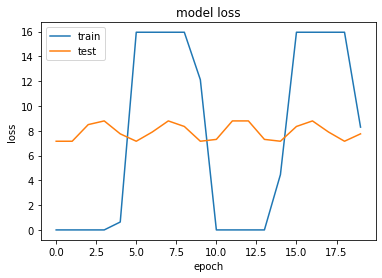

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title("model loss")

plt.ylabel("loss")

plt.xlabel("epoch")

plt.legend(["train","test"],loc="upper left")

plt.imshow()
